# ACS6420 Advanced project
## Rolls-Royce Undergraduate project - Anomaly detection in discrete sequences
### Author: Aldair M Silva
### Supervisor: Visakan
Date created: 13/10/2021

In [3]:
from datetime import date
print('Updated: ', date.today().strftime('%d/%m/%Y'))

Updated:  06/05/2022


Import libraries

In [28]:
import io
import csv
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

In [29]:
random.seed(1)

Import data

In [30]:
normal_raw = 'normalTrafficTraining.txt'
anomaly_raw = 'anomalousTrafficTest.txt'

normal_parse = 'normalRequestTraining.txt'
anomaly_parse = 'anomalousRequestTest.txt'

## Prototype 1

File handling functions

In [31]:
# File parsing function
def parse_file(file_in, file_out):
    fin = open(file_in)
    fout = io.open(file_out, "w", encoding="utf-8")
    lines = fin.readlines()
    res = []
    
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith("GET"):
            res.append("GET" + line.split(" ")[1])
        elif line.startswith("POST") or line.startswith("PUT"):
            url = line.split(' ')[0] + line.split(' ')[1]
            j = 1
            while True:
                if lines[i + j].startswith("Content-Length"):
                    break
                j += 1
            j += 1
            data = lines[i + j + 1].strip()
            url += '?' + data
            res.append(url)
    for line in res:
        line = urllib.parse.unquote(line).replace('\n','').lower()
        fout.writelines(line + '\n')
    print ("finished parse ",len(res)," requests")
    fout.close()
    fin.close()

# File reading function
def loadData(file):
    with open(file, 'r', encoding="utf8") as f:
        data = f.readlines()
    result = []
    for d in data:
        d = d.strip()
        if (len(d) > 0):
            result.append(d)
    return result


def removepunctuation(text)
    new_text = text.translate(str.maketrans('', '', string.punctuation))
    return new_text

In [35]:
a = 'My name is aldair^%^$%^';
ap = removepunctuation(a);
ap

'My name is aldair^%^$%^'

In [32]:
normal_data_p = parse_file(normal_raw,normal_parse)
anomaly_data_p = parse_file(anomaly_raw,anomaly_parse)

normal_data = removepunctuation(normal_data_p)
anomaly_data = removepunctuation(anomaly_data_p)

finished parse  36000  requests
finished parse  25065  requests


AttributeError: 'NoneType' object has no attribute 'replace'

In [16]:
good_requests = loadData('normalRequestTraining.txt')
bad_requests = loadData('anomalousRequestTest.txt')

all_requests = bad_requests + good_requests
yBad = [1] * len(bad_requests)
yGood = [0] * len(good_requests)
y = yBad + yGood

In [17]:
idx_random = np.random.randint(0,len(all_requests), 35000)
short_all_request = [all_requests[i] for i in idx_random]
y_short = [y[i] for i in idx_random]
idx_random

array([43474, 51352, 42898, ..., 57936, 26304,  4108])

In [18]:
len(short_all_request)

35000

In [19]:
len(y_short)

35000

### Doc2Vector

    This section uses TF-IDF (Term frequency-Inverse Document Frequency) to transform the words in the document into numberical values.
The values are determines by how many times they appear in the document, and the inverse frequency of the same word in other documents/corpus.
This process is called "vectorization", and is calculated as tf=log[1+fre(term,document)], idf=log(1+total_number_of_pages/number_of_pages_containing_term).
Both resutls are then multiplied. The values range from 0 to 1, 0 being very relevant and 1 being less relevant.
Relevance in this case means the word is unique (less common/less frequent) in and across documents, and the opposite for less relevant words (such as what/the/is/in for instance).

For this text analysis, the words will be taken as characters due to the nature of the document (web request), resulting in roughly 62 features extracted from 61065 requests)

In [20]:
vectorizer = TfidfVectorizer(min_df=0.0, analyzer="char", sublinear_tf=True, ngram_range=(1, 1))
X = vectorizer.fit_transform(all_requests)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
pd.DataFrame(X_train[:])
X.shape 

(61065, 62)

Feature analysis will show all the characters used as features. As it can be observed below, numbers, letters, special and unknwon characters are taken into account. 
The unknown features in this model exist because the vectorizer works in english language, and the document contains latin words/characters, although not very frequent.

In [16]:
# Analysis of features extracted

feature_array = np.array(vectorizer.get_feature_names())    # Get feature names
print("Feature names: ", feature_array)

X_dense = X.todense()


Feature names:  ['!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2'
 '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' '_' 'a' 'b' 'c'
 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u'
 'v' 'w' 'x' 'y' 'z' '|' '~' '�']


In [17]:
np.where(X_dense[0,:])[1]

array([ 4,  5,  6,  9, 10, 13, 14, 15, 16, 17, 20, 23, 25, 26, 28, 30, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51,
       52, 53, 55, 61])

In [18]:
print("X vector matrix: \n", X_dense[1,:])
print("\nMax value in vector: ", np.max(X_dense))
print("Min value in vector: ", np.min(X_dense))

X vector matrix: 
 [[0.         0.         0.         0.         0.18097812 0.21023937
  0.30790935 0.         0.         0.23630751 0.31051935 0.
  0.         0.04615579 0.11910886 0.07728439 0.07973636 0.09084181
  0.         0.         0.10557915 0.         0.         0.09579201
  0.         0.07728439 0.35438396 0.         0.18346481 0.
  0.07029278 0.         0.         0.16610625 0.14655533 0.13446727
  0.14289961 0.15074784 0.09395338 0.         0.09579201 0.16082227
  0.0900221  0.1413723  0.13446727 0.14265478 0.12985367 0.16272356
  0.127431   0.         0.19422    0.13446727 0.15074784 0.12476878
  0.         0.10387202 0.         0.         0.         0.
  0.         0.25187405]]

Max value in vector:  0.7642262116462106
Min value in vector:  0.0


In [19]:
# Features.csv gets created in the current working directory
#with open('Features.csv', 'w', newline = '') as csvfile:
#    my_writer = csv.writer(csvfile, delimiter = ' ')
#    my_writer.writerow(X_array)


### PCA
Explore how components affect model dimensions.
Understand how relevant the method is to identify best features that can best pick anomalous data.
Check explained variance ratios, try using a treshold to separate best features.

In [41]:
short_X_dense = X_dense[:35000,:]
pca = PCA(n_components=7, svd_solver='full')
X_PCA = pca.fit_transform(short_X_dense)
X_embedded = TSNE(n_components=2).fit_transform(short_X_dense)

Understand and evaluate the meaning of variance in PCA dataset.

Through experiments, it has been noticed that the number of X_dense values selected has a direct correlation with the variance ratio. Having about 47% of the dataset represented overall, with around 35,000 points. with PCA1 having the highest portion.

In [49]:
print("Variance ratio: ", pca.explained_variance_ratio_)
print("Singular values: ", pca.singular_values_)

Variance ratio:  [0.2784991  0.11020161 0.08168849 0.0664765  0.04867837 0.04351048
 0.03544259]
Singular values:  [55.36899248 34.82961603 29.98714723 27.05133983 23.14849379 21.8852574
 19.75229091]


PCA plots

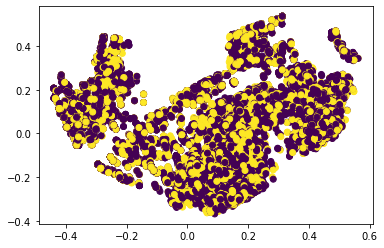

In [50]:
# Scatter plot
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y_short)


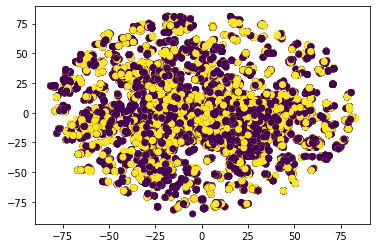

In [51]:
# Linear plot
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_short)

Logistic regression model

In [24]:
lgs = LogisticRegression()
lgs.fit(X_train, y_train)
y_pred = lgs.predict(X_test)
score_test = metrics.accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print ("Score Logistic Regression :",score_test)
print ("Confusion Matrix: ")
print (matrix)

Score Logistic Regression : 0.7995087336244542
Confusion Matrix: 
[[9742 1103]
 [2570 4905]]


/Users/audazmm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Decision tree model
Write on understanding of rules.
    - What do numbers mean for tree.plot_tree()

Plot decision tree.

In [47]:
dtc = tree.DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
score_test = metrics.accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
print ("Score Decesion Tree :",score_test)
print ("Confusion Matrix: ")
print (matrix)


Score Decesion Tree : 0.8267467248908297
Confusion Matrix: 
[[7914 2931]
 [ 243 7232]]


[Text(167.4, 181.2, 'X[14] <= 0.284\ngini = 0.484\nsamples = 42745\nvalue = [25155, 17590]'),
 Text(83.7, 108.72, 'X[50] <= 0.177\ngini = 0.487\nsamples = 28337\nvalue = [11882, 16455]'),
 Text(41.85, 36.23999999999998, '\n  (...)  \n'),
 Text(125.55000000000001, 36.23999999999998, '\n  (...)  \n'),
 Text(251.10000000000002, 108.72, 'X[13] <= 0.122\ngini = 0.145\nsamples = 14408\nvalue = [13273, 1135]'),
 Text(209.25, 36.23999999999998, '\n  (...)  \n'),
 Text(292.95, 36.23999999999998, '\n  (...)  \n')]

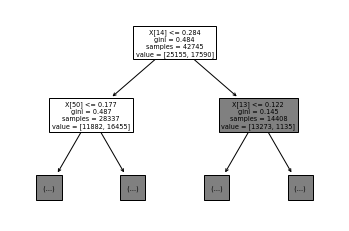

In [48]:
tree.plot_tree(dtc,max_depth=1)

SVM model

In [27]:
linear_svm=LinearSVC(C=1)
linear_svm.fit(X_train, y_train)
y_pred = linear_svm.predict(X_test)
score_test = metrics.accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
print ("Score Linear SVM :",score_test)
print ("Confusion Matrix: ")
print (matrix)


Score Linear SVM : 0.8186681222707424
Confusion Matrix: 
[[9830 1015]
 [2307 5168]]


### Random forest model

Write on rules used for random forest models

In [28]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
score_test = metrics.accuracy_score(y_test, y_pred)
print ("Score Random Forest :",score_test)
print ("Confusion Matrix: ")
print (matrix)

Score Random Forest : 0.9807860262008734
Confusion Matrix: 
[[9830 1015]
 [2307 5168]]


AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

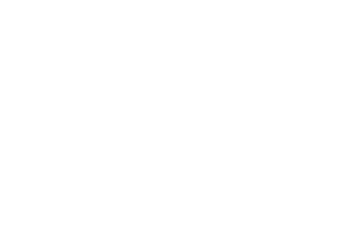

In [40]:
# Plot random forest